# EUMETSAT Sentinel-3 OLCI_OC4ME ***vs*** OLCI_NN

## Ocean Colour data acquired by the Sentinel-3 Ocean and Land Colour Instrument (OLCI) provides the means for us to observe and monitor marine ecosystems.

# OLCI Chlorophyll product comparison

This aim of this code is to allow you to compare the standard CHL_OC4ME and complex water CHL_NN products over a given scene. It is recommended that you familiarise yourself with Prac 1 prior to running this.

The first step in any python code is usually to import libraries that you will need. Libraries are usually code modules that perform specific tasks or provide specific capability (e.g. statistical analysis or plotting routines). In this case we will import the xarray library for handling netCDF files, the numpy library which will help to conduct various operations on the data, and the matplotlib plotting library to generate some images. We will also import the os library, that allows python access to some command-line-eqsue capability like 'list directory', as well as the python library that governs the reporting of warning (so that we can turn them off here, and make the code run without being so 'noisy').

In [1]:
%matplotlib inline

# Import the libraries you need with its alias (short 'nickname')
# Data processing
import xarray as xr
import netCDF4 as nc
import numpy as np
import os

# Data vis/ mapping
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import warnings
warnings.filterwarnings('ignore')

Usually we also define functions at the top of a Python script. Functions are routines that can be called elsewhere in our script and perform a specific task. Typically we would use a function to take care of any process that we are going to perform more than once. The box below defines a function that will mask our data according to quality flags. We will call this function later on.

In [2]:
def flag_data_fast(flags_we_want, flag_names, flag_values, flag_data, flag_type = 'WQSF'):
    flag_bits = np.uint64()
    if flag_type == 'SST':
        flag_bits = np.uint8()
    elif flag_type == 'WQSF_lsb':
        flag_bits = np.uint32()
    
    for flag in flags_we_want:
        try:
            flag_bits = flag_bits | flag_values[flag_names.index(flag)]
        except:
            print(flag + " not present")
    
    return (flag_data & flag_bits) > 0

As in Practical 1, you will need to point it to where you have downloaded/ saved your data files. If you keep your scripts and files in the same folder, you will not need to set the full path to the data file. However you may want to store things in different places and so it is good practice to be specific. To help to find your data, please complete the MYPATH variable below with the output generated by the /Configuration_Testing/Data_Path_Checker.ipynb Jupyter notebook in the Configuration_Testing folder.

In [3]:
pwd # Confirming your current path

'/Users/lbiermann1/Dropbox/2425_ipython_ynb/S3_OLCI_L2'

In [28]:
# Replace my path with your path (from pwd command above)
inpath = os.path.join('/Users/lbiermann1/Dropbox/2425_ipython_ynb/S3_OLCI_L2/data')
infile = 'S3B_OL_2_WFR____20210202T075412_20210202T075712_20210903T194631_0180_048_320______MAR_R_NT_003.SEN3' 

In [29]:
filename_oc = 'chl_oc4me.nc'
filename_nn = 'chl_nn.nc'
file_latlon = 'geo_coordinates.nc'

In [30]:
# Latitude and Longitude from geo_coordinates
lat_lon = xr.open_dataset(os.path.join(inpath, infile, file_latlon))
lat = lat_lon.latitude
lon = lat_lon.longitude

# CHL concentrations calculated using the tradtional OC4Me Algorithm
OLCI_oc = xr.open_dataset(os.path.join(inpath, infile, filename_oc))
OC4me = OLCI_oc.CHL_OC4ME.data

# CHL concentrations calculated using the Neural Net (ML) Algorithm
OLCI_nn = xr.open_dataset(os.path.join(inpath, infile, filename_nn))
CHLnn = OLCI_nn.CHL_NN.data

# Close holders
lat_lon.close()
OLCI_oc.close()
OLCI_nn.close()

#### Subset.

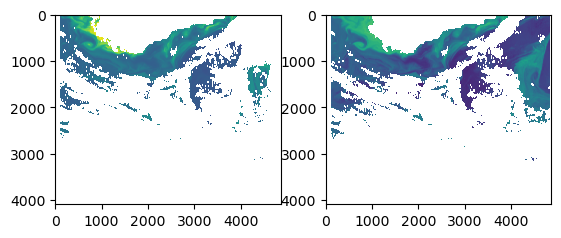

In [31]:
# Quick Check of your [CHL] Data
f, axarr = plt.subplots(1,2) #subplot(r,c) provide the no. of rows and columns
axarr[0].imshow(OC4me)
axarr[1].imshow(CHLnn)

In [34]:
# Subset using Rows and Column Values from above Plots
row1 = 0
row2 = 1500
col1 = 100
col2 = 4000

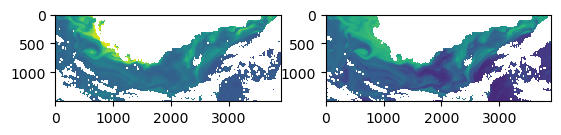

In [35]:
# Now Subset your Data to speed up Processing and Plotting
LAT_ss = lat[row1:row2, col1:col2 ]
LON_ss = lon[row1:row2, col1:col2 ]
OC4_ss = OC4me[row1:row2,col1:col2]
CHL_ss = CHLnn[row1:row2,col1:col2]

# Quick Check of your subset [CHL] Data
f, axarr = plt.subplots(1,2) #subplot(r,c) provide the no. of rows and columns
axarr[0].imshow(OC4_ss)
axarr[1].imshow(CHL_ss)

In [36]:
# FLAG and MASK clouds
######################
inflag = 'wqsf.nc'
# Choose and Add Flags to Mask Cloud
flag_vars = ['CLOUD', 'TURBID_ATM', 'CLOUD_AMBIGUOUS', 'CLOUD_MARGIN']
FLAG_file = xr.open_dataset(os.path.join(inpath, infile, inflag))

# Flag names
flag_name = FLAG_file['WQSF'].flag_meanings.split(' ')
# flag bit values
flag_vals = FLAG_file['WQSF'].flag_masks
# flag field itself
FLAGS = FLAG_file.variables['WQSF'].data
FLAG_file.close()

# Make flag mask using the function we defined at the start: "flag_data_fast" (cell2)
flag_mask = flag_data_fast(flag_vars, flag_name, flag_vals, FLAGS, flag_type='WQSF')
flag_mask = flag_mask.astype(float)
flag_mask[flag_mask == 0.0] = np.nan

# subset flag mask
FLAG_subset1 = flag_mask[row1:row2, col1:col2]

In [37]:
CHL_ss[np.isfinite(FLAG_subset1)] = np.nan
OC4_ss[np.isfinite(FLAG_subset1)] = np.nan

# CHL values in the product are log10 distributed, so we linearise prior to calculating differences.
CHL_Dif = 10**CHL_ss - 10**OC4_ss

# Get the 95% percentile of the finite values of the array (helps with plotting).
Max_Val = np.percentile(np.abs(CHL_Dif[np.isfinite(CHL_Dif)]), 95)

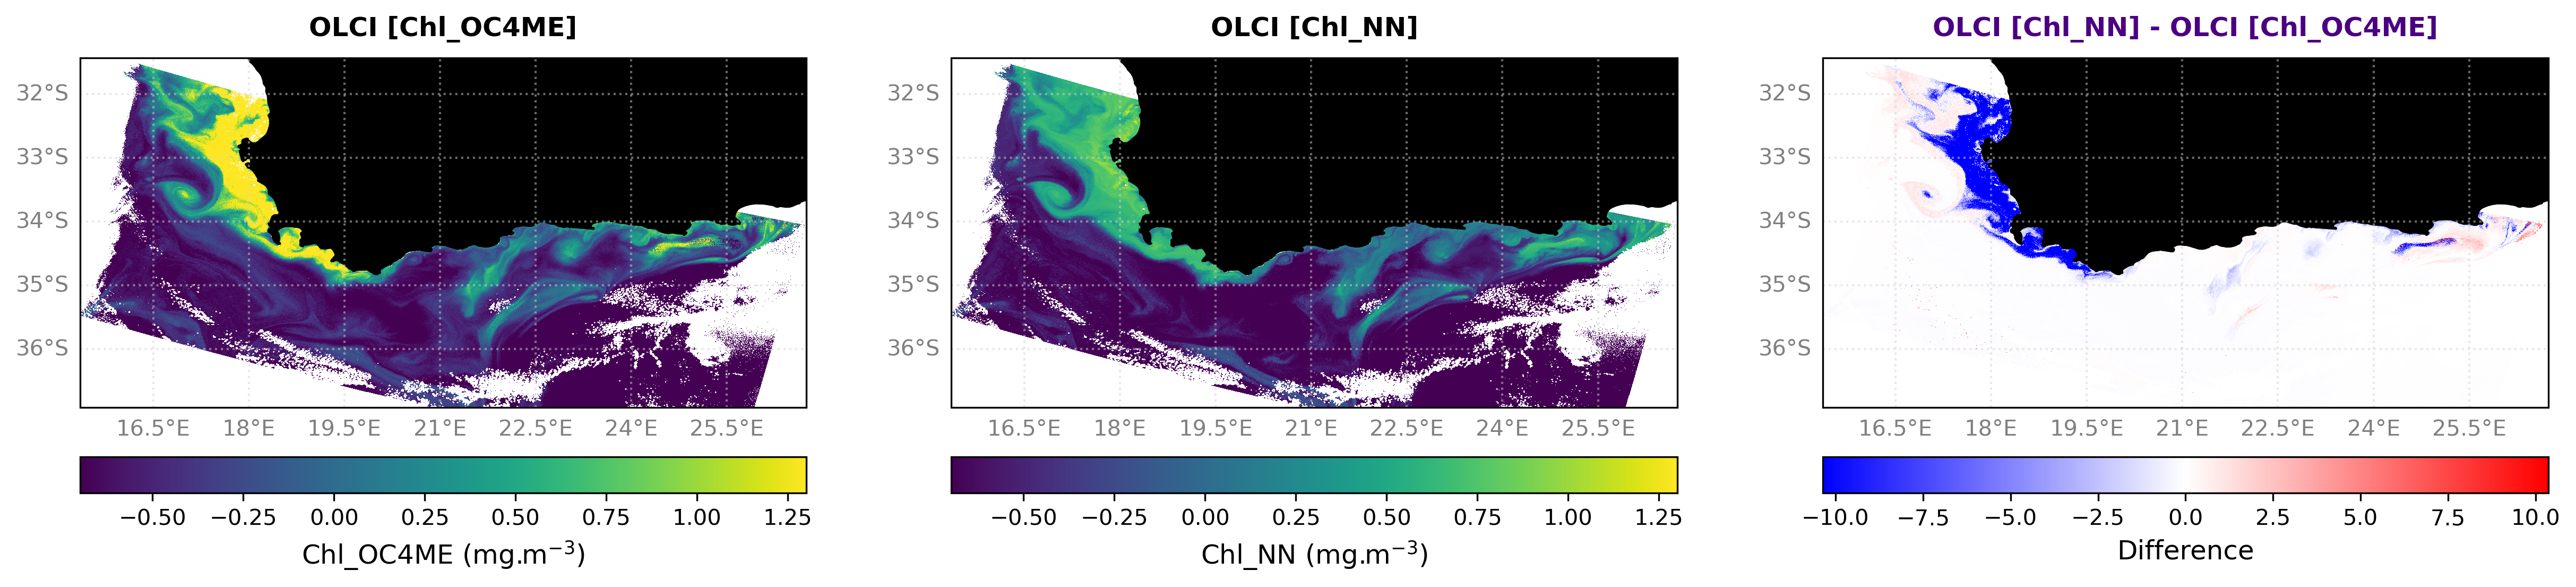

In [39]:
fig1 = plt.figure(figsize=(20, 20), dpi=300)

gs = gridspec.GridSpec(1, 3)
# Set the Data and Output projections
data_projection = ccrs.PlateCarree()
output_projection=ccrs.PlateCarree()
land_resolution = '10m'
land_poly = cfeature.NaturalEarthFeature('physical', 'land', "10m",
                                        edgecolor='k',
                                        facecolor='black')
latmin=np.nanmin(LAT_ss)
latmax=np.nanmax(LAT_ss)
lonmin=np.nanmin(LON_ss)
lonmax=np.nanmax(LON_ss)

# Set axes1
ax = plt.subplot(gs[0,0], projection = ccrs.PlateCarree(central_longitude= 0.0))
ax.set_extent([lonmin+1, lonmax, latmin+1, latmax])
ax.add_feature(land_poly)
ax.coastlines('10m')
gl = ax.gridlines(crs = ccrs.PlateCarree(), draw_labels = True,
             linewidth = 1, color = 'lightgray', alpha = 0.5, linestyle = ':')
gl.xlabels_top  = False
gl.ylabels_right= False
gl.xlabel_style = {'size': 10, 'color': 'gray'}
gl.ylabel_style = {'size': 10, 'color': 'gray'}

# Plot CHL_OC4ME
im = plt.pcolormesh(LON_ss, LAT_ss, OC4_ss, vmin = np.log10(0.2), vmax = np.log10(20),
                    transform = data_projection, cmap = plt.cm.viridis)
# Add Colourbar
cbar= plt.colorbar(orientation= "horizontal", fraction = 0.05, pad = 0.02) 
cbar.set_label('Chl_OC4ME (mg.m$^{-3}$)', fontsize = 12)
# Add Subtitle
plt.title('OLCI [Chl_OC4ME]', fontsize = 12, weight = 'bold', pad = 10)

# Set axes2
ax = plt.subplot(gs[0,1], projection = ccrs.PlateCarree(central_longitude= 0.0))
ax.set_extent([lonmin+1, lonmax, latmin+1, latmax])
ax.add_feature(land_poly)
ax.coastlines('10m')
gl = ax.gridlines(crs = ccrs.PlateCarree(), draw_labels = True,
             linewidth = 1, color = 'lightgray', alpha = 0.5, linestyle = ':')
gl.xlabels_top  = False
gl.ylabels_right= False
gl.xlabel_style = {'size': 10, 'color': 'gray'}
gl.ylabel_style = {'size': 10, 'color': 'gray'}

# Plot CHL_NN
im = plt.pcolormesh(LON_ss, LAT_ss, CHL_ss, vmin = np.log10(0.2), vmax = np.log10(20),
                    transform = data_projection, cmap = plt.cm.viridis)
# Add colourbar
cbar= plt.colorbar(orientation= "horizontal", fraction = 0.05, pad = 0.02) 
cbar.set_label('Chl_NN (mg.m$^{-3}$)', fontsize = 12)
# Add Subtitle
plt.title('OLCI [Chl_NN]', fontsize = 12, weight = 'bold', pad = 10)

# Set axes3
ax = plt.subplot(gs[0,2], projection = ccrs.PlateCarree(central_longitude= 0.0))
ax.set_extent([lonmin+1, lonmax, latmin+1, latmax])
ax.add_feature(land_poly)
ax.coastlines('10m')
gl = ax.gridlines(crs = ccrs.PlateCarree(), draw_labels = True,
             linewidth = 1, color = 'lightgray', alpha = 0.5, linestyle = ':')
gl.xlabels_top  = False
gl.ylabels_right= False
gl.xlabel_style = {'size': 10, 'color': 'gray'}
gl.ylabel_style = {'size': 10, 'color': 'gray'}

# Plot Differences
im = plt.pcolormesh(LON_ss, LAT_ss, CHL_Dif, vmin = (Max_Val*-1), vmax = Max_Val, 
                    transform = data_projection, cmap = plt.cm.bwr) 
                    #vmin = (np.nanmin(CHL_Dif)+5), vmax = np.nanmax((CHL_Dif)-5) 
# Add colourbar
cbar= plt.colorbar(orientation= "horizontal", fraction = 0.05, pad = 0.02) 
cbar.set_label('Difference', fontsize = 12)
# Add Subtitle
plt.title('OLCI [Chl_NN] - OLCI [Chl_OC4ME]', color = 'indigo', fontsize = 12, weight = 'bold', pad = 10)

plt.show()

In [13]:
# Uncomment the comment below to save your figure (2)
# fig1.savefig('CHL_Algorithm_Comparison.png', bbox_inches='tight')